# Miniproject - Neuroscience: cellular and circuit mechanisms (BIO-482)

- This notebook produces the figures for **part 1** of the miniproject.

#### Importing libraries

In [1]:
import os
import sys
from mat73 import loadmat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### Importing helper functions
 Feel free to check out what these functions do in the corresponding files, `helpers.py` or `utils.py`. 
 - `helpers.py` contains functions to analyze membrane potential recording data
 - `utils.py` contains functions useful for other things e.g. plotting

In [2]:
base_path = os.getcwd()
base_path = base_path.replace('notebooks', 'scripts') # note: if you have notebooks twice in your base_path, this won't work
sys.path.insert(1, base_path)

from helpers import *
from utils import remove_top_right_frame, jitter_scatterplot

# Test

# Load data
Load the data as `.pkl` file (converted from MATLAB) as a dataframe:

In [8]:
# Make paths
main_dir = '/Users/bisi/Documents/PhD/TA/BIO-482/bio482_miniproject/' # EDIT
print('Main working directory:', main_dir)
figure_path = os.path.join(main_dir, 'figures')
os.makedirs(figure_path, exist_ok=True)
data_path = os.path.join(main_dir, 'data') #if your folder is organized differently, just specify the full path to the .mat file

# Load
fname = 'data_bio482.pkl'
data_df = pd.read_pickle(os.path.join(data_path, fname))

Main working directory: /Users/bisi/Documents/PhD/TA/BIO-482/bio482_miniproject/


Inspect how the dataframe looks like:

In [9]:
data_df.head(3)

,Cell_APThreshold_Slope,Cell_Anatomy,Cell_Counter,Cell_Depth,Cell_ID,Cell_Layer,Cell_TargetedBrainArea,Cell_Type,Cell_tdTomatoExpressing,Mouse_DateOfBirth,...,Sweep_Counter,Sweep_MembranePotential,Sweep_MembranePotential_SamplingRate,Sweep_PassiveContactTimes,Sweep_QuietTimes,Sweep_StartTime,Sweep_Type,Sweep_WhiskerAngle,Sweep_WhiskerAngle_SamplingRate,Sweep_WhiskingTimes
0,10.0,L2/3,1.0,229.0,SC901_1,L2/3,C2,EXC,False,NaN,...,1.0,"[-0.044009375, -0.044028125, -0.0439875, -0.04...",20000.0,"[[4.567, 4.713], [7.327, 7.519], [14.481, 14.6...","[[0.002, 4.564], [4.606, 6.09], [14.634, 15.52...",2005.0,active touch,"[2.740000000000009, 2.740000000000009, 2.74000...",100.0,"[[6.118, 6.326], [7.942, 13.856]]"
1,10.0,L2/3,1.0,229.0,SC901_1,L2/3,C2,EXC,False,NaN,...,2.0,"[-0.046275, -0.04629375, -0.046259375, -0.0462...",20000.0,"[[15.274999999999999, 15.375], [16.247, 16.643...","[[0.002, 4.496], [5.558, 6.626], [13.406, 15.2...",2005.0,active touch,"[2.680000000000007, 2.680000000000007, 2.68000...",100.0,"[[4.7, 5.196], [6.696, 11.15], [12.032, 13.006..."
2,10.0,L2/3,1.0,229.0,SC901_1,L2/3,C2,EXC,False,NaN,...,3.0,"[-0.041896875, -0.0419125, -0.041909375, -0.04...",20000.0,"[[4.347000000000001, 7.0390000000000015], [8.2...","[[0.002, 2.128], [6.252, 7.01], [7.15, 20.0]]",2005.0,passive contact,"[1.4958937492820894, 1.5019819900587095, 1.509...",100.0,"[[2.15, 3.652], [4.362, 5.848]]"


In [8]:
data_df.describe() #shows numeric columns only

,Cell_APThreshold_Slope,Cell_Counter,Cell_Depth,Mouse_DateOfBirth,Sweep_Counter,Sweep_MembranePotential_SamplingRate,Sweep_StartTime,Sweep_WhiskerAngle_SamplingRate
count,831.000000,831.000000,814.000000,602.000000,831.000000,831.0,831.000000,831.0
mean,15.330927,1.450060,296.168305,2015.315615,3.669073,20000.0,2013.281588,100.0
std,7.035538,0.780545,140.527726,0.713587,3.605550,0.0,3.761586,0.0
min,0.000000,1.000000,97.000000,2013.000000,1.000000,20000.0,2005.000000,100.0
25%,10.000000,1.000000,185.000000,2015.000000,1.000000,20000.0,2013.000000,100.0
50%,15.000000,1.000000,234.000000,2015.000000,3.000000,20000.0,2015.000000,100.0
75%,20.000000,2.000000,427.000000,2016.000000,4.000000,20000.0,2016.000000,100.0
max,40.000000,5.000000,665.000000,2017.000000,27.000000,20000.0,2017.000000,100.0


# Part 1 - Properties of cortical neurons during quiet wakefulness: suprathreshold/subthreshold activity and cell class [3/10 marks]

Set general general parameters that we will use throughout part 1:

In [9]:
sweep_type = 'free whisking'
time_window = 2    # time window to analyze Vm (s)
freq_band_lim = [1, 10, 30, 90] # low- and high-frequency band limits (Hz)

 Select data for specific one sweep type (sweep and trial are synonymous):

In [10]:
data_df_subset = data_df[data_df['Sweep_Type']==sweep_type] 

Find all the unique recorded cells present in the data:

In [11]:
all_cells = np.unique(data_df_subset.Cell_ID)
print('Number of cells:', len(all_cells))

Number of cells: 232


# Here we start the analysis
- Here, we iterate over cells and trials per cell to compute, collect relevant data.

In [12]:
verbose=False #set to 0 to hide individual AP plots

# Initialize a dictionary to store data for all cell
result_dict = {'cell_id': all_cells, 
          'cell_type':[], # required for cell-type identification
          # Data we'll collect for Part 1a
          'firing_rate': [], 
          'ap_threshold': [], 
          'ap_duration': [], 
          # Data we'll collect for Part 1b
          'mean_vm':[],
          'std_vm':[],
          'fft_low':[],
          'fft_high':[]
        }

result_fft_cell_type = {'EXC':[],'SST':[], 'VIP':[],'PV':[]}

exc_cell_counter = 0

# Iterate over each cell identities to collect desired data
cell_list = sorted(np.unique(data_df_subset.Cell_ID), reverse=True) #NOTE: DO NOT START WITH AC32 bc. no AP and undefined ap_params contnet
for idx, cell in enumerate(cell_list):
    if idx%100==0:
        print('Cell {}/{}'.format(idx, np.unique(data_df_subset.Cell_ID).shape[0]))
    
    # Get mouse name and cell number from cell identifier
    mouse = cell.split('_')[0]
    cell_count = float(cell.split('_')[1])
    
    # Get data subset for that cell
    cell_df = data_df_subset[data_df_subset.Cell_ID==cell]
    
    # Get cell type 
    cell_type = cell_df.Cell_Type.values[0]
    result_dict['cell_type'] += [cell_type]
    
    # Get sweeps/trials recorded for that cell, that we are going to iterate over
    trial_list = cell_df.Sweep_Counter.values
    
    # Init. cell recording specific quantities: a unique duration, yielding a unique number of APs
    tot_rec_duration = 0
    tot_number_ap = 0
    
    # Initialize empty lists to get data for each trial/sweep
    # Part 1a
    tot_ap_thresh = []
    tot_ap_duration = []
    # Part 1b
    tot_mean_vm = []
    tot_std_vm = []
    tot_fft = []
    
    # For that cell, iterate over trials
    for trial in trial_list:
        #if idx % 100 == 0: # print every 100 iteration  
            #print('Cell {},  trial {}'.format(cell, int(trial)))
        if cell_type == 'EXC':
            exc_cell_counter += 1
        
        # Get current trial data
        cell_trial_df = cell_df[cell_df.Sweep_Counter==trial]
        
        # Get the sampling rate and membrane potential (and derivative) from that sweep
        sr_vm = cell_trial_df['Sweep_MembranePotential_SamplingRate'].values[0] #[0] to get the content of the array
        membrane_potential = cell_trial_df['Sweep_MembranePotential'].values[0]
        ap_vm_deriv_thresh = cell_trial_df['Cell_APThreshold_Slope'].values[0]
        
        # Get and update recording duration for that cell by adding trial duration
        trial_rec_duration = len(membrane_potential)/sr_vm
        tot_rec_duration += trial_rec_duration
        
        # Detection of action potentials for that trial, and update total number of APs for that cell
        #ap_params = None
        ap_params = Function_Detect_APs(membrane_potential, sr_vm, ap_vm_deriv_thresh) 
        tot_number_ap += ap_params.shape[0]
          
        # Check if this trial contains any AP...
        ap_duration = []
        if (ap_params.any()):
            ap_thresh_times = ap_params[:,0]
            ap_thresh_vm = ap_params[:,1]
            ap_peak_times = ap_params[:,2]
            ap_peak_vm = ap_params[:,3]
            ap_duration = ap_params[:,5] #check for no-APs (cells with no spikes in ALL trials:EXC5,16 FR=0, AP_dur=np.nan)

            #... if so, cut-out individual APs to keep subthreshold Vm only
            vm_sub = Function_CutAPs(membrane_potential, sr_vm, ap_peak_times, ap_thresh_times)
            
            
        # Else if no AP, subthreshold Vm is just Vm
        else:
            
            vm_sub = membrane_potential.copy()

        # Once Vm_sub is obtained:
        # Compute subthreshold Vm mean and standard deviation
        mean_vm, std_vm = Function_SubThrsVm(vm_sub, sr_vm, trial_rec_duration)
        
        # Compute trial FFT
        fft = Function_Compute_FFTs(vm_sub, sr_vm, time_window)
        
        #Update current variables from the current trial
        # Part 1a
        tot_ap_thresh += [np.concatenate([ap_thresh_vm])]
        tot_ap_duration += [ap_duration]
        # Part 1b
        tot_mean_vm += [mean_vm]
        tot_std_vm += [std_vm]
        tot_fft +=  [fft]
        
        # Optional plotting: show AP and AP peak times
        ap_peak_index=np.round(ap_peak_times * sr_vm)  
        if verbose:
            fig, ax = plt.subplots(1,1, figsize=(10,2), dpi=300)
            remove_top_right_frame(ax)
            ax.set_title('Cell {},  trial {}'.format(cell, int(trial)))
            ax.plot(membrane_potential, lw=0.5,  zorder=0)
            ax.scatter(ap_peak_index, ap_peak_vm, lw=0.5, marker='+', color='r')
            ax.set_xlabel('Time (samples)')
            ax.set_ylabel('Membrane \n potential (V)')
            plt.show()

    # Once iterated over all trials for that cell, append cell data lists to the result dictionary
  
    # Part 1a
    result_dict['firing_rate'] += [tot_number_ap / tot_rec_duration] # <- just the firing rate formula
    result_dict['ap_threshold'] += [np.nanmean(np.concatenate(tot_ap_thresh))] #<-concatenate trials, get trial-average
    result_dict['ap_duration'] += [np.nanmean(np.concatenate(tot_ap_duration))]

    
    # Part 1b
    result_dict['mean_vm'] += [np.nanmean(np.concatenate(tot_mean_vm))]
    result_dict['std_vm'] += [np.nanmean(np.concatenate(tot_std_vm))]
    
    # Compute mean FFT over trials
    tot_fft = np.nanmean(np.concatenate(tot_fft, axis=1), 1)
    #Store mean cell FFT
    result_fft_cell_type[cell_type] += [tot_fft] 
    
    # We need to find which point (sample) in the FFT correspond to which frequency
    pt1 = int(freq_band_lim[0] * fft.shape[0] / (sr_vm/2) ) + 1 #1Hz into FFT point
    pt2 = int(freq_band_lim[1] * fft.shape[0] / (sr_vm/2) ) + 1 #int: slicing requires integers
    result_dict['fft_low'] += [tot_fft[pt1:pt2].mean()]
    
    pt3 = int(freq_band_lim[2] * fft.shape[0] / (sr_vm/2) ) + 1
    pt4 = int(freq_band_lim[3] * fft.shape[0] / (sr_vm/2) ) + 1 
    result_dict['fft_high'] += [tot_fft[pt3:pt4].mean()]

## Convert each dictionary lists as numpy arrays (convenient to make dataframes)
result_dict = {key: np.array(result_dict[key]) for key in result_dict.keys()}

print('Done!')

Cell 0/232
Cell 100/232


/Users/bisi/Documents/PhD/TA/BIO-482/bio482_miniproject/python/scripts/helpers.py:18: RuntimeWarning: invalid value encountered in true_divide
  AP_Thrs_Onset = np.diff(np.divide(Vm_Deriv - Vm_Deriv_Thrs, np.abs(Vm_Deriv - Vm_Deriv_Thrs)))
/var/folders/vr/p3nztt9d26q4905fqmd3ljw00000gq/T/ipykernel_20974/46832084.py:129: RuntimeWarning: Mean of empty slice
  result_dict['ap_duration'] += [np.nanmean(np.concatenate(tot_ap_duration))]


Cell 200/232


/Users/bisi/Documents/PhD/TA/BIO-482/bio482_miniproject/python/scripts/helpers.py:52: RuntimeWarning: invalid value encountered in true_divide
  sAP_OnOff = np.diff(np.divide(sAP_Seg, np.abs(sAP_Seg)))  # compute the binary signal


Done!


Format result dictionary as dataframe:

In [13]:
result_df = pd.DataFrame(result_dict)
result_df.head(3)

,cell_id,cell_type,firing_rate,ap_threshold,ap_duration,mean_vm,std_vm,fft_low,fft_high
0,AP032_1,EXC,0.875000,-0.040795,0.608929,-0.064378,0.005948,0.000763,0.000070
1,AP032_2,EXC,1.857143,-0.040812,0.993269,-0.056189,0.005208,0.000635,0.000090
2,AP035_1,EXC,2.100000,-0.037562,0.786111,-0.058273,0.006374,0.000775,0.000053


## Inspect and compute statistics per cell type
We have a now a dictionary with different data for each cell. The `pd.DataFrame` function `describe()` provides summary statistics over the entire dataframe.

In [14]:
result_df.describe()

,firing_rate,ap_threshold,ap_duration,mean_vm,std_vm,fft_low,fft_high
count,232.000000,232.000000,230.000000,232.000000,232.000000,232.000000,232.000000
mean,10.291331,-0.040790,0.767249,-0.054247,0.005126,0.000643,0.000063
std,15.298859,0.003367,0.440015,0.005861,0.001553,0.000224,0.000023
min,0.000000,-0.048334,0.116667,-0.069672,0.001333,0.000153,0.000019
25%,1.133373,-0.042997,0.462953,-0.057528,0.003940,0.000479,0.000044
50%,4.270151,-0.040938,0.661604,-0.053780,0.005044,0.000629,0.000058
75%,14.412500,-0.039061,0.978438,-0.050454,0.006072,0.000779,0.000077
max,127.119565,-0.028422,2.439216,-0.038182,0.010189,0.001389,0.000130


We can also inspect per cell type, given that we included this information in `result`. Note that we can also group and show statistics using other categories.

In [15]:
pd.set_option('display.max_columns', None) #this is just to print all columns
result_df.groupby('cell_type').describe()

firing_rate                                                        \
                count       mean        std       min        25%        50%   
cell_type                                                                     
EXC              86.0   1.822975   2.298222  0.000000   0.320833   0.862500   
PV               49.0  29.343396  21.821187  2.083333  16.486486  27.152174   
SST              72.0   6.597538   6.313915  0.382353   2.354167   4.464943   
VIP              25.0  12.718557  10.894143  0.005208   5.643333   7.483333   

                                 ap_threshold                                \
                 75%         max        count      mean       std       min   
cell_type                                                                     
EXC         2.766532   11.650000         86.0 -0.039869  0.003557 -0.046335   
PV         34.833333  127.119565         49.0 -0.041382  0.002356 -0.045868   
SST         7.801087   30.384615         72.0 -0.041763  0.003158 -0.048334   
VIP        18.683333   41.700000         25.0 -0.039998  0.004058 -0.045422   

                                                  ap_duration            \
                25%       50%       75%       max       count      mean   
cell_type                                                                 
EXC       -0.042038 -0.040294 -0.038336 -0.028422        84.0  1.073068   
PV        -0.043008 -0.041307 -0.039693 -0.034840        49.0  0.372908   
SST       -0.043603 -0.041913 -0.039583 -0.034625        72.0  0.637514   
VIP       -0.043840 -0.039914 -0.037786 -0.029954        25.0  0.886243   

                                                                      mean_vm  \
                std       min       25%       50%       75%       max   count   
cell_type                                                                       
EXC        0.455177  0.116667  0.792743  0.975480  1.338248  2.439216    86.0   
PV         0.135135  0.162334  0.286229  0.346137  0.429584  0.773966    49.0   
SST        0.294848  0.250549  0.470131  0.575098  0.705945  1.907738    72.0   
VIP        0.356503  0.514782  0.617245  0.802230  1.026439  2.182439    25.0   

                                                                       \
               mean       std       min       25%       50%       75%   
cell_type                                                               
EXC       -0.058215  0.005977 -0.069672 -0.062525 -0.058026 -0.054594   
PV        -0.052489  0.003800 -0.060553 -0.055180 -0.052712 -0.050498   
SST       -0.052026  0.004456 -0.063655 -0.055150 -0.051752 -0.048911   
VIP       -0.050440  0.004883 -0.058287 -0.053417 -0.052047 -0.047169   

                    std_vm                                                    \
                max  count      mean       std       min       25%       50%   
cell_type                                                                      
EXC       -0.038375   86.0  0.005337  0.001179  0.002618  0.004543  0.005329   
PV        -0.041178   49.0  0.006238  0.001519  0.003351  0.005151  0.006106   
SST       -0.043044   72.0  0.004017  0.000994  0.002298  0.003335  0.003736   
VIP       -0.038182   25.0  0.005410  0.002072  0.001333  0.004271  0.005674   

                              fft_low                                          \
                75%       max   count      mean       std       min       25%   
cell_type                                                                       
EXC        0.006050  0.008932    86.0  0.000687  0.000169  0.000331  0.000560   
PV         0.006926  0.009964    49.0  0.000804  0.000247  0.000381  0.000641   
SST        0.004577  0.006885    72.0  0.000481  0.000134  0.000285  0.000386   
VIP        0.006800  0.010189    25.0  0.000646  0.000259  0.000153  0.000512   

                                        fft_high                      \
                50%       75%       max    count      mean       std   
cell_type              

# Plots
Let's just define a dictionary for color coding cell classes, and a list to keep cell type order fixed:

In [16]:
class_color = {'EXC':'k',
               'PV':'indianred',
               'VIP':'royalblue',
               'SST':'darkorange'} 
cell_class_order = ['EXC', 'PV', 'SST', 'VIP']

The advantage of using `pd.DataFrame` is that we can use the library `seaborn`, which allow for fast and clear visualization. However, for more customized figures, seaborn sometimes makes things complicated. 

In [17]:
import seaborn as sns

Text(0.5, 1.0, 'Mean firing rate - free whisking')

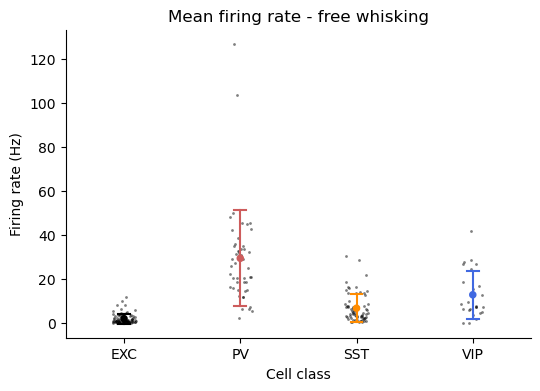

In [18]:
fig, ax = plt.subplots(1,1,figsize=(6,4), dpi=100) #define 1x1 figure layout 
remove_top_right_frame(ax)

# Plot individual data points
sns.stripplot(data=result_df,
                ax=ax,
                x='cell_type',
                y='firing_rate',
                order=cell_class_order,
                color='k',
                s=2,
                alpha=0.5,
                zorder=0)

# Plot mean and standard deviation
sns.pointplot(data=result_df,
                ax=ax,
                x='cell_type',
                y='firing_rate',
                order=cell_class_order,
                palette=class_color,
                estimator=np.mean,
                errorbar='sd',
                markers='.',
                join=False,
                scale=1,
                errwidth=1.5,
                capsize=0.1, 
                #zorder=0 # HERE
             )

# Specify axes
plt.legend([],[], frameon=False)
ax.set_xlabel('Cell class')
ax.set_ylabel('Firing rate (Hz)')
ax.set_title('Mean firing rate - free whisking')

## Compare mean firing rates across cells and cell types

- However, for more customized figures, seaborn sometimes makes things complicated. 
- Here, we would like individual observations to be shifted relative to the errorbar, which we cannot easily do with seaborn. With matplotlib alone, we can do like this:

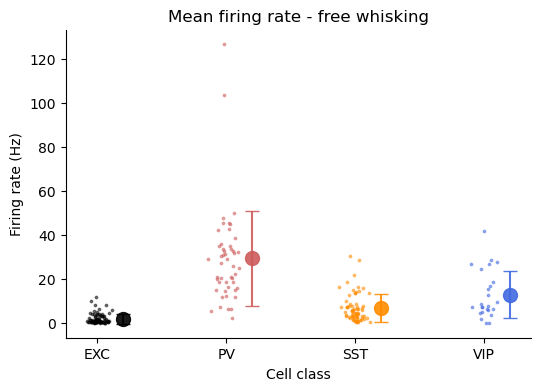

In [19]:
# Define figure
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4), dpi=100)
remove_top_right_frame(ax)

# Iterate over cell class
for i, c_type in enumerate(cell_class_order):
    
    n_cells = len(result_df[result_df.cell_type==c_type])
    obs_locations = [i]*n_cells #create a list int, to place observations categorically
    obs_values = result_df[result_df.cell_type==c_type]['firing_rate'].values
    
    # Show individual observations (scatterplot with added x-axis jitter to avoid overplotting)
    jitter_scatterplot(x=obs_locations, 
                       y=obs_values,
                       s=3, 
                       alpha=0.5, 
                       c=class_color[c_type])
    
    # Show mean and standard deviation
    ax.errorbar(x=i+0.2,
                 y=np.mean(obs_values),
                 yerr=np.std(obs_values), #errobarsize is standard deviation
                 marker='o', 
                 ms=10, 
                 capsize=5,
                 alpha=0.9, 
                 c=class_color[c_type])
    
# Set xtick labels and legend
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(cell_class_order)
ax.set_xlabel('Cell class')
ax.set_ylabel('Firing rate (Hz)')
ax.set_title('Mean firing rate - free whisking')

# Save figure
fname = os.path.join(figure_path, 'mean_firing_rate_free_whisking.png')
plt.savefig(fname=fname, dpi='figure', format='png', bbox_inches='tight')
    

## Compare mean action potential duration across cells and cell types

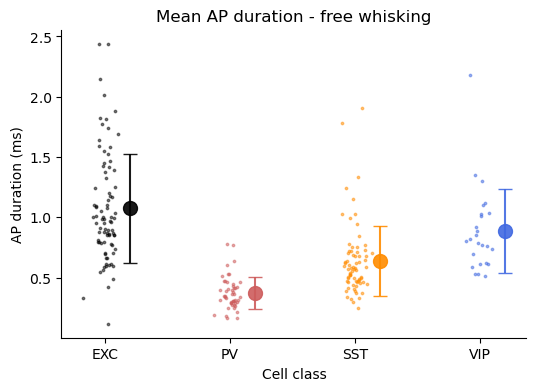

In [20]:
# Define figure
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4), dpi=100)
remove_top_right_frame(ax)

# Iterate over cell class
for i, c_type in enumerate(cell_class_order):
    
    n_cells = len(result_df[result_df.cell_type==c_type])
    obs_locations = [i]*n_cells #create a list int, to place observations categorically
    obs_values = result_df[result_df.cell_type==c_type]['ap_duration'].values
    
    # Show individual observations (scatterplot with added x-axis jitter to avoid overplotting)
    jitter_scatterplot(x=obs_locations, 
                       y=obs_values,
                       s=3, 
                       alpha=0.5, 
                       c=class_color[c_type])
    
    # Show mean and standard deviation
    ax.errorbar(x=i+0.2,
                 y=np.nanmean(obs_values),
                 yerr=np.nanstd(obs_values), #errobarsize is standard deviation
                 marker='o', 
                 ms=10, 
                 capsize=5, 
                 alpha=0.9, 
                 c=class_color[c_type])
    
# Set xtick labels and legend
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(cell_class_order)
ax.set_xlabel('Cell class')
ax.set_ylabel('AP duration (ms)')
ax.set_title('Mean AP duration - free whisking')
    
    
# Save figure
fname = os.path.join(figure_path, 'mean_ap_duration_free_whisking.png')
plt.savefig(fname=fname, dpi='figure', format='png', bbox_inches='tight')
       


## Compare mean firing rate with AP duration across cells and cell types

We import a model class from `scikit-learn`, a standard machine learning library:

In [21]:
from sklearn.linear_model import LinearRegression 

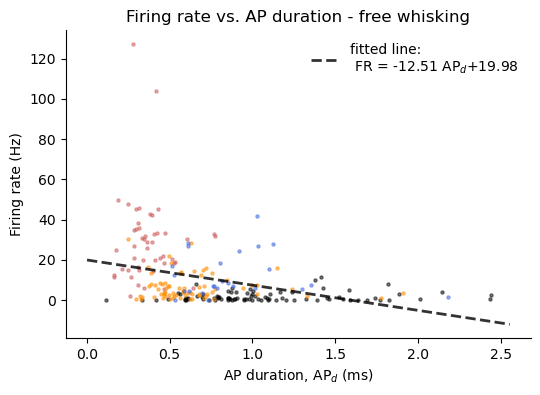

In [22]:
# Define figure
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4), dpi=100)
remove_top_right_frame(ax)

# Plot data 
for i, c_type in enumerate(cell_class_order):
    
    data_fr = result_df[result_df.cell_type==c_type]['firing_rate'].values
    data_ap_dur = result_df[result_df.cell_type==c_type]['ap_duration'].values
    
    ax.scatter(x=data_ap_dur, 
               y=data_fr,
               s=5, 
               alpha=0.5, 
               c=class_color[c_type])

# Axes
ax.set_xlabel('AP duration, AP$_d$ (ms)')
ax.set_ylabel('Firing rate (Hz)')
ax.set_title('Firing rate vs. AP duration - free whisking')
    
    
# Fit linear regression model and plot regression line
data_fr_all = result_df['firing_rate'].values
data_ap_dur_all = result_df['ap_duration'].values
nan_ids = np.isnan(data_fr_all) + np.isnan(data_ap_dur_all) #finding NaNs 

model = LinearRegression().fit(X=data_ap_dur_all[~nan_ids].reshape(-1, 1), #must be 2D 
                               y=data_fr_all[~nan_ids])
x_range = np.array(plt.xlim())
y_fit = model.intercept_ + model.coef_[0] * x_range

ax.plot(x_range, 
        y_fit, 
        ls='--', 
        linewidth=2,
        color='k',
        label='fitted line: \n FR = {:.2f} AP$_d$+{:.2f}'.format(model.coef_[0], model.intercept_), 
        alpha=0.8)
ax.legend(frameon=False)

# Save figure
fname = os.path.join(figure_path, 'mean_firingrate_vs_apduration_free_whisking.png')
plt.savefig(fname=fname, dpi='figure', format='png', bbox_inches='tight')

Or with seaborn:

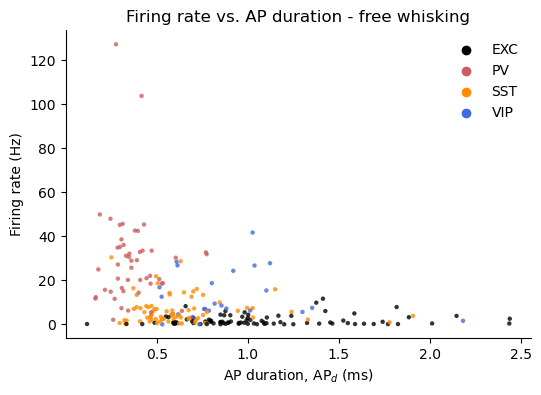

In [23]:
# Define figure
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4), dpi=100)
remove_top_right_frame(ax)

sns.scatterplot(data=result_df,
                ax=ax,
               x='ap_duration',
               y='firing_rate',
               hue='cell_type',
               hue_order=cell_class_order,
               palette=class_color,
               ec=None,
                s=10,
               alpha=0.8)

# Axes
ax.set_xlabel('AP duration, AP$_d$ (ms)')
ax.set_ylabel('Firing rate (Hz)')
ax.set_title('Firing rate vs. AP duration - free whisking')
ax.legend(frameon=False)

## Mean membrane potential Vm per cell type

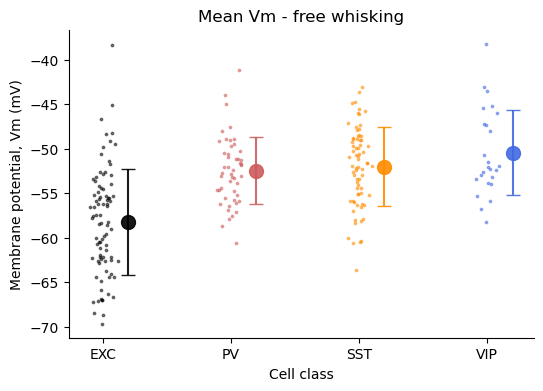

In [24]:
# Define figure
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4), dpi=100)
remove_top_right_frame(ax)

# Iterate over cell class
for i, c_type in enumerate(cell_class_order):
    
    n_cells = len(result_df[result_df.cell_type==c_type])
    obs_locations = [i]*n_cells #create a list int, to place observations categorically
    obs_values = result_df[result_df.cell_type==c_type]['mean_vm'].values * 1000 #in mV
    
    # Show individual observations (scatterplot with added x-axis jitter to avoid overplotting)
    jitter_scatterplot(x=obs_locations, 
                       y=obs_values,
                       s=3, 
                       alpha=0.5, 
                       c=class_color[c_type])
    
    # Show mean and standard deviation
    ax.errorbar(x=i+0.2,
                 y=np.nanmean(obs_values),
                 yerr=np.nanstd(obs_values), #errobarsize is standard deviation
                 marker='o', 
                 ms=10, 
                 capsize=5, 
                 alpha=0.9, 
                 c=class_color[c_type])
    
# Set xtick labels and legend
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(cell_class_order)
ax.set_xlabel('Cell class')
ax.set_ylabel('Membrane potential, Vm (mV)')
ax.set_title('Mean Vm - free whisking')
    
    
# Save figure
fname = os.path.join(figure_path, 'mean_vm_free_whisking.png')
plt.savefig(fname=fname, dpi='figure', format='png', bbox_inches='tight')
       


### Mean SD of the Vm per cell type

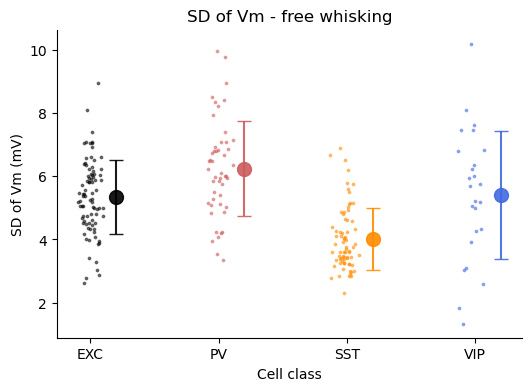

In [25]:
# Define figure
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4), dpi=100)
remove_top_right_frame(ax)

# Iterate over cell class
for i, c_type in enumerate(cell_class_order):
    
    n_cells = len(result_df[result_df.cell_type==c_type])
    obs_locations = [i]*n_cells #create a list int, to place observations categorically
    obs_values = result_df[result_df.cell_type==c_type]['std_vm'].values * 1000 #in mV
    
    # Show individual observations (scatterplot with added x-axis jitter to avoid overplotting)
    jitter_scatterplot(x=obs_locations, 
                       y=obs_values,
                       s=3, 
                       alpha=0.5, 
                       c=class_color[c_type])
    
    # Show mean and standard deviation
    ax.errorbar(x=i+0.2,
                 y=np.nanmean(obs_values),
                 yerr=np.nanstd(obs_values), #errobarsize is standard deviation
                 marker='o', 
                 ms=10, 
                 capsize=5, 
                 alpha=0.9, 
                 c=class_color[c_type])
    
# Set xtick labels and legend
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(cell_class_order)
ax.set_xlabel('Cell class')
ax.set_ylabel('SD of Vm (mV)')
ax.set_title('SD of Vm - free whisking')
    
    
# Save figure
fname = os.path.join(figure_path, 'mean_sd_vm_free_whisking.png')
plt.savefig(fname=fname, dpi='figure', format='png', bbox_inches='tight')
       


## Mean FFT per cell type

To plot the mean FFT per cell type, remember we stored these mean FFT, per cell, in the variable `result_fft_cell_type`.

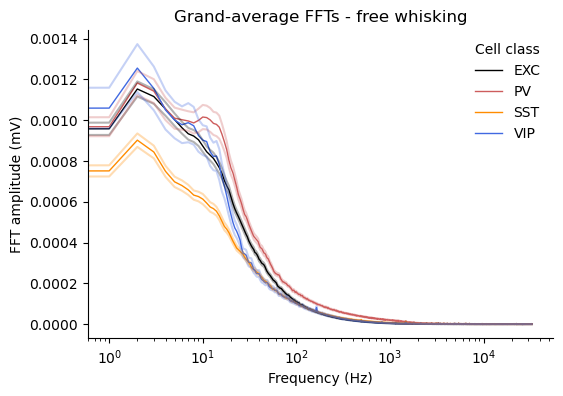

In [26]:
# Define figure
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4), dpi=100)
remove_top_right_frame(ax)

# Iterate over cell class
for i, c_type in enumerate(cell_class_order):
    
    # Compute mean and std of FFT per cell class
    mean_fft = np.nanmean(np.stack(result_fft_cell_type[c_type],axis=1),axis=1)
    std_fft = np.nanstd(np.stack(result_fft_cell_type[c_type],axis=1),axis=1)
    n_cells = np.stack(result_fft_cell_type[c_type],axis=1).shape[1]
    
    #Plot mean FFT 
    ax.plot(mean_fft, 
            lw=1, 
            c=class_color[c_type], 
            label=c_type,
            zorder=1)
    
    # Get standard error of the mean
    sem = std_fft / np.sqrt(n_cells)
    
    ax.semilogx(mean_fft+sem, 
                    color=class_color[c_type], 
                    alpha=0.3)
    ax.semilogx(mean_fft-sem, 
                    color=class_color[c_type], 
                    alpha=0.3)
    
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('FFT amplitude (mV)')
ax.set_title('Grand-average FFTs - free whisking')
ax.legend(frameon=False, loc='upper right', title='Cell class')

# Save figure
fname = os.path.join(figure_path, 'grand_average_mean_fft_free_whisking.png')
plt.savefig(fname=fname, dpi='figure', format='png', bbox_inches='tight')




Or, using a provided function:

In [27]:
from utils import plot_avg_mean_fft

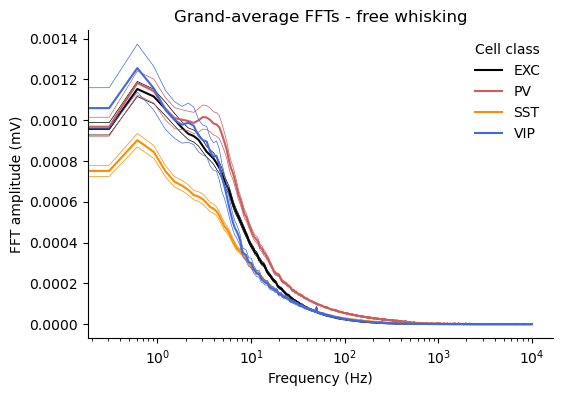

In [28]:
# Define figure
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4), dpi=100)
remove_top_right_frame(ax)

# Iterate over cell class
for i, c_type in enumerate(cell_class_order):
    
    #Provide as input a matrix (stacked average FFTs)
    fft_matrix = np.stack(result_fft_cell_type[c_type], axis=1)
    plot_avg_mean_fft(ax, fft_matrix, sr_vm, c_type, class_color[c_type])

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('FFT amplitude (mV)')
ax.set_title('Grand-average FFTs - free whisking')
ax.legend(frameon=False, loc='upper right', title='Cell class')

# Save figure
fname = os.path.join(figure_path, 'grand_average_mean_fft_free_whisking_2.png')
plt.savefig(fname=fname, dpi='figure', format='png', bbox_inches='tight')


## Mean FFT amplitude, low frequencies, per cell type

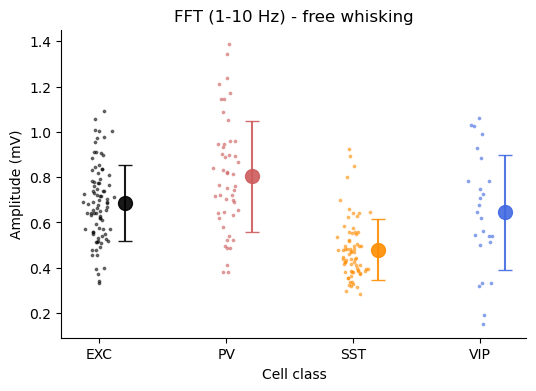

In [29]:
# Define figure
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4), dpi=100)
remove_top_right_frame(ax)

# Iterate over cell class
for i, c_type in enumerate(cell_class_order):
    
    n_cells = len(result_df[result_df.cell_type==c_type])
    obs_locations = [i]*n_cells #create a list int, to place observations categorically
    obs_values = result_df[result_df.cell_type==c_type]['fft_low'].values * 1000 #in mV
    
    # Show individual observations (scatterplot with added x-axis jitter to avoid overplotting)
    jitter_scatterplot(x=obs_locations, 
                       y=obs_values,
                       s=3, 
                       alpha=0.5, 
                       c=class_color[c_type])
    
    # Show mean and standard deviation
    ax.errorbar(x=i+0.2,
                 y=np.nanmean(obs_values),
                 yerr=np.nanstd(obs_values), #errobarsize is standard deviation
                 marker='o', 
                 ms=10, 
                 capsize=5, 
                 alpha=0.9, 
                 c=class_color[c_type])
    
# Set xtick labels and legend
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(cell_class_order)
ax.set_xlabel('Cell class')
ax.set_ylabel('Amplitude (mV)')
ax.set_title('FFT (1-10 Hz) - free whisking')
    
    
# Save figure
fname = os.path.join(figure_path, 'mean_fft_low_free_whisking.png')
plt.savefig(fname=fname, dpi='figure', format='png', bbox_inches='tight')
       


## Mean FFT amplitude, high frequencies, per cell type

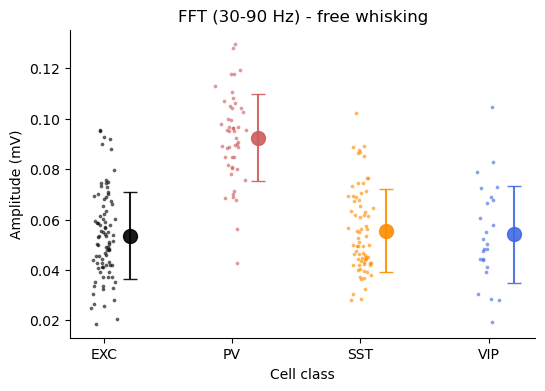

In [30]:
# Define figure
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4), dpi=100)
remove_top_right_frame(ax)

# Iterate over cell class
for i, c_type in enumerate(cell_class_order):
    
    n_cells = len(result_df[result_df.cell_type==c_type])
    obs_locations = [i]*n_cells #create a list int, to place observations categorically
    obs_values = result_df[result_df.cell_type==c_type]['fft_high'].values * 1000 #in mV
    
    # Show individual observations (scatterplot with added x-axis jitter to avoid overplotting)
    jitter_scatterplot(x=obs_locations, 
                       y=obs_values,
                       s=3, 
                       alpha=0.5, 
                       c=class_color[c_type])
    
    # Show mean and standard deviation
    ax.errorbar(x=i+0.2,
                 y=np.nanmean(obs_values),
                 yerr=np.nanstd(obs_values), #errobarsize is standard deviation
                 marker='o', 
                 ms=10, 
                 capsize=5, 
                 alpha=0.9, 
                 c=class_color[c_type])
    
# Set xtick labels and legend
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(cell_class_order)
ax.set_xlabel('Cell class')
ax.set_ylabel('Amplitude (mV)')
ax.set_title('FFT (30-90 Hz) - free whisking')
    
    
# Save figure
fname = os.path.join(figure_path, 'mean_fft_high_free_whisking.png')
plt.savefig(fname=fname, dpi='figure', format='png', bbox_inches='tight')
       


**End of notebook**.